In [1]:

import os,sys,inspect
currentdir = os.path.abspath(inspect.getfile(inspect.currentframe()))
parentdir = os.path.dirname(currentdir)
rootdir = os.path.dirname(parentdir)
sys.path.insert(0,parentdir) 
sys.path.insert(0,rootdir) 

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from python import analysis
from python import utils
from python import plot

import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


In [2]:
# Load pairwise distance matrices and associated graphs
vocab, wd_pw, img_pw, G_wd, G_img = utils.load_graphs_and_pw(q=0.1, dist_type="eu")


### Forced choice plots

/opt/anaconda3/envs/align/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/apple/projects/Age_of_acquisition/AoA_final/python/plot.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["given"] = [re.sub("Mode", "", x) for x in df["given"]]
/Users/apple/projects/Age_of_acquisition/AoA_final/python/plot.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

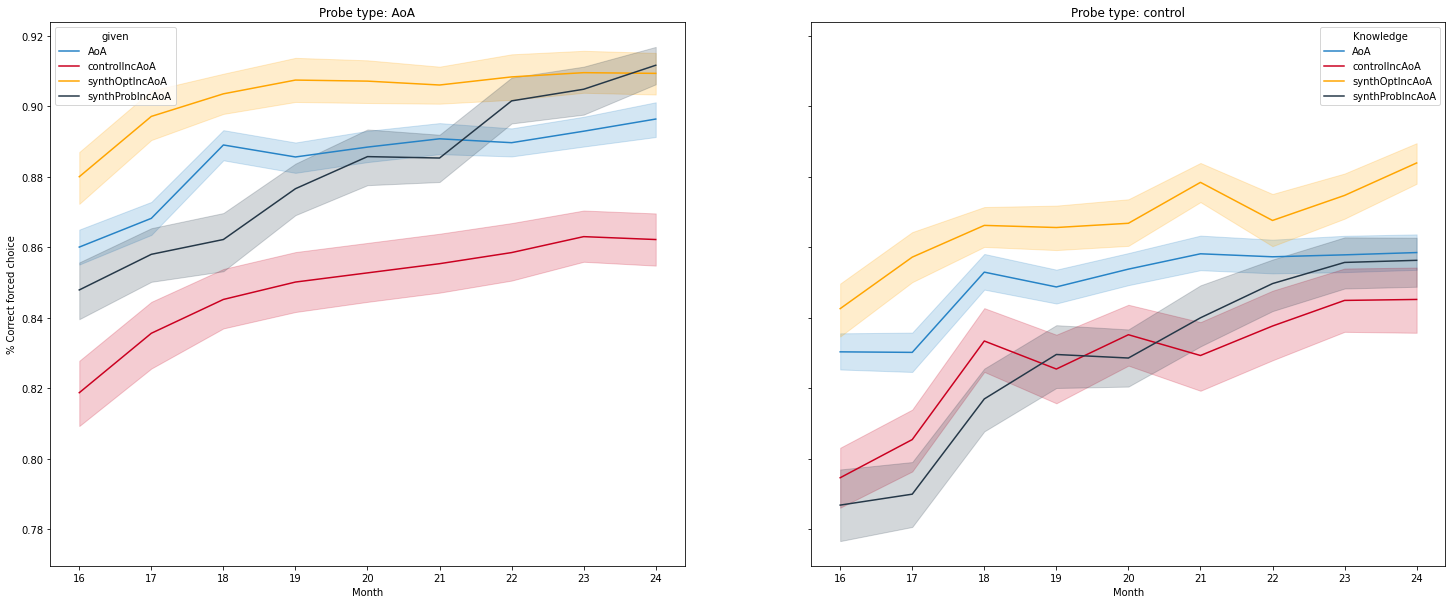

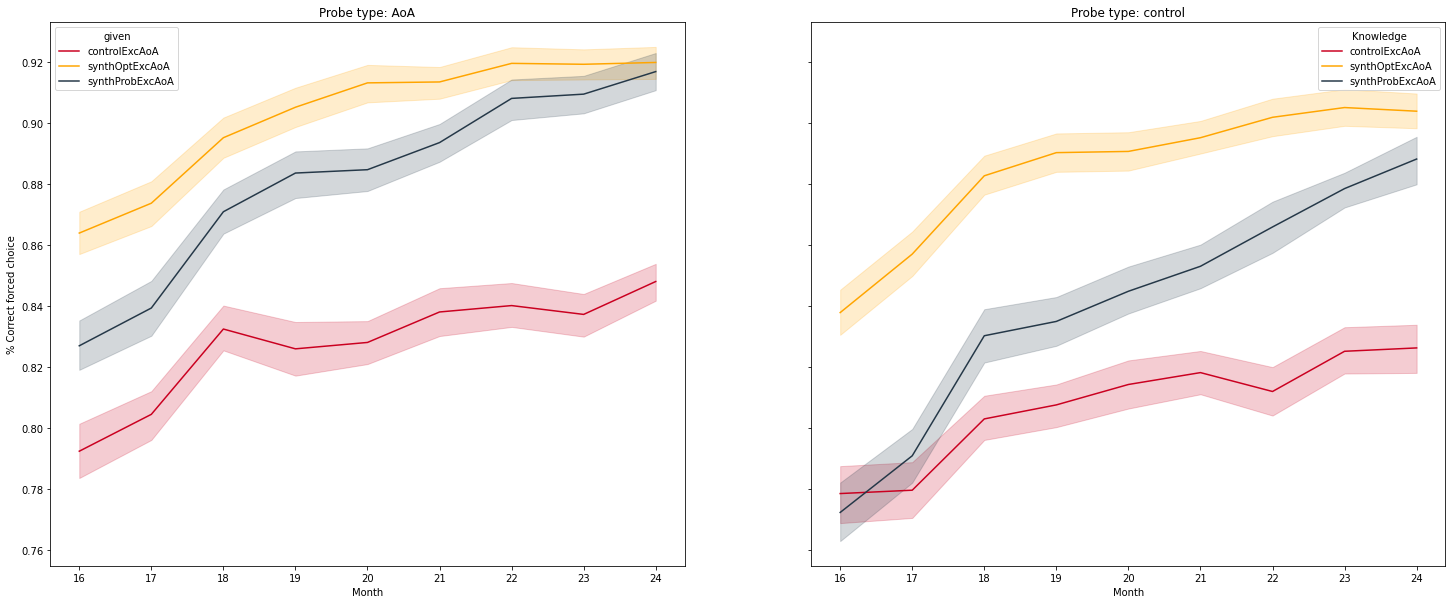

In [3]:
pp0 = pd.read_csv(
            os.path.join(rootdir,
                       "results/probe_pair/probe_pair_optimal.csv"),
            header=0, index_col=0)
pp1 = pd.read_csv(
            os.path.join(rootdir,
                         "results/probe_pair/probe_pair_probmatch.csv"),
            header=0, index_col=0)
pp2 = pd.read_csv(
            os.path.join(rootdir,
                         "results/probe_pair/probe_pair_emp.csv"),
            header=0, index_col=0)


pps = pd.concat([
                pp0,
                pp1,
                pp2
                ])

conditions = ["controlIncAoA", 
             "synthOptIncAoA",
             "synthProbIncAoA", 
             "AoA"] 

plot.probeExpt_results_shady(pps, conditions=conditions,
                fn=os.path.join(rootdir,
                            "results/probe_pair/probe_pair_include_optinc.png"),
                months=[x for x in range(16, 25)],
                probe_conds=["AoA", "control"])

conditions = ["controlExcAoA", 
             "synthOptExcAoA", 
             "synthProbExcAoA",
              ] 

plot.probeExpt_results_shady(pps, conditions=conditions,
                fn=os.path.join(rootdir,
                            "results/probe_pair/probe_pair_exclude.png"),
                months=[x for x in range(16, 25)],
                probe_conds=["AoA", "control"])



### Load sample sequences for regression

In [4]:
sample_mets = pd.read_csv(
                os.path.join(
                                rootdir,
                                "assets/sample_mets/sample_mets.csv"
                            ), index_col=0, header=0)
sample_mets = sample_mets.loc[sample_mets["month"]<=24]
#sample_mets = sample_mets.drop(columns=["Unnamed: 0.1"])
sample_mets = sample_mets.dropna()
sample_mets.drop_duplicates()
print(sample_mets)

          condition  pid  month  wd_min_dist_full  wd_max_dist_full  \
0               AoA    0     16          0.458300          0.915594   
1               AoA    0     17          0.458480          0.918496   
2               AoA    0     18          0.460174          0.916357   
3               AoA    0     19          0.463367          0.917515   
4               AoA    0     20          0.461293          0.918220   
...             ...  ...    ...               ...               ...   
5543  controlExcAoA   99     22          0.493757          0.920354   
5544  controlExcAoA   99     23          0.497400          0.919652   
5545  controlExcAoA   99     23          0.497400          0.919652   
5546  controlExcAoA   99     24          0.500737          0.920065   
5547  controlExcAoA   99     24          0.500737          0.920065   

      wd_mean_dist_full  wd_min_dist_subs  wd_max_dist_subs  \
0              0.715035          0.596942          0.760313   
1              0.7176

In [5]:
df0 = pd.read_csv(os.path.join(
                                rootdir,
                                "results/seq_features/sequence_coverage_monthwise.csv"
                            ), header=0, index_col=0)

df1 = pd.read_csv(os.path.join(
                                rootdir,
                                "results/seq_features/sequence_graph_mets_monthwise.csv"
                            ), header=0, index_col=0)

df2 = pd.read_csv(os.path.join(
                                rootdir,
                                "results/seq_features/sequence_nx_mets_monthwise.csv"
                            ), header=0, index_col=0)
df2 = df2[[x for x in df2.columns
                               if ("25" not in x) & ("50" not in x)]]
# Average measures across modalities
df2 = analysis.get_modality_averages(df2)

# Get only modality agnostic cols
df2 = df2[
        [x for x in df2.columns
         if ("img" not in x) and ("wd" not in x)]
        ]

sample_mets = df0.merge(
                    df1, on=["condition", "pid", "month"]
                ).merge(
                    df2, on=["condition", "pid", "month"]
                ).drop_duplicates()
sample_mets = sample_mets.loc[sample_mets["month"]<=24]

sample_mets = sample_mets[[x for x in sample_mets.columns if "rel" not in x]]
sample_mets = sample_mets[sample_mets["condition"] != "controlIncAoA"]
print(sample_mets)

          condition  pid  n_acq_x  month  coverage_wd  coverage_img  coverage  \
0               AoA    0        0     16     0.553892      0.340018  0.446955   
1               AoA    0        0     17     0.589361      0.343547  0.466454   
2               AoA    0        0     18     0.659336      0.375882  0.517609   
3               AoA    0        0     19     0.693176      0.391663  0.542420   
4               AoA    0        0     20     0.704548      0.391663  0.548106   
...             ...  ...      ...    ...          ...           ...       ...   
5538  controlExcAoA   99        0     20     0.778729      0.849268  0.813998   
5540  controlExcAoA   99        0     21     0.797046      0.849268  0.823157   
5542  controlExcAoA   99        0     22     0.825628      0.850747  0.838187   
5544  controlExcAoA   99        0     23     0.840871      0.850747  0.845809   
5546  controlExcAoA   99        0     24     0.852995      0.858891  0.855943   

      wd_min_dist_full  wd_

In [6]:
# Input into regression model framework for selection of best vars

sample_mets["given_cat"] = [x == "AoA" for x in sample_mets["condition"]]

X = sample_mets.drop(columns=["month", "pid", "condition", "given_cat"]
                             + [x for x in sample_mets.columns if "acq" in x]
                             + [x for x in sample_mets.columns if "wd" in x or "img" in x]
                             + [x for x in sample_mets.columns if ("clustering" in x)|("betweenness" in x)] 
                             + [x for x in sample_mets.columns if (("max" in x) or ("min" in x) and ("deg" in x))] # These mean something strange and hard to interpret+ [x for x in sample_mets.columns if "n_acq" in x] +
                             + [x for x in sample_mets.columns if ("skew" in x) & ("dist" in x)]  
                    ) 

#X = X.drop(columns=["n_given"])
y_bin = sample_mets["given_cat"]
print(X.columns)

Index(['coverage', 'min_dist_full', 'mean_dist_full', 'min_dist_subs',
       'mean_dist_subs', 'mean_deg_full', 'mean_deg_subs', 'deg_skew_full',
       'deg_skew_subs'],
      dtype='object')


In [7]:
rs=50

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y_bin,
                                                    test_size=0.2,
                                                    random_state=0
                                                    )
# Range of n selected features to test
rng = [x for x in range(1, len(X.columns) + 1)]

# Collect scores to compare values of n
aics = []
bics = []
selected_vars = []

# Cycle through values of n
for n_feat in rng:
    # Input to feature selector
    model = LogisticRegression(
                                penalty="l2",
                                solver="liblinear",
                                max_iter=100000,
                                random_state=rs
                              )

    # Feature selector
    selector = RFE(
                    model,
                    n_features_to_select=n_feat,
                    step=1
                   )

    selector.fit(X_train, y_train)

    selected_names = [X_train.columns[i]
                      for i, x in enumerate(selector.support_)
                      if x
                     ]
    selected_vars.append(selected_names)


    # Predict using constructed model
    preds = selector.predict(X_test)

    # Gather metrics for model comparison
    loglik = analysis.calculate_logprob(selector, X_test, np.expand_dims(y_test, 1))
    aic = analysis.calculate_aic(len(selected_names), loglik)
    bic = analysis.calculate_bic(len(selected_names), X_train.shape[0], loglik)
    bics.append(bic)
    aics.append(aic)
    

model_df = pd.DataFrame(
                {"n_vars":rng,
                 "bic":bics,
                 "aic":aics,
                 "vars":selected_vars}
            )

# Select best model
best_N = rng[np.argmin(aics)]
print("Best N: ", best_N)

# Construct best model
model = LogisticRegression(penalty="l2",
                           solver="liblinear",
                           max_iter=100000,
                           random_state=rs
                          )

selector = RFE(
                model,
                n_features_to_select=best_N,
                step=1
                )

selector.fit(X_train, y_train)

selected_names = [X_train.columns[i]
                  for i, x in enumerate(selector.support_)
                  if x
                 ]

model = LogisticRegression(penalty="l2",
                           solver="liblinear",
                           max_iter=100000,
                           random_state=rs
                          )

model.fit(X_train[selected_names], y_train)

preds = model.predict(X_test[selected_names])

print(dict(
            zip(
                selected_names,
                [x for x in model.coef_[0] if x != 0]
            )
        ))

acc = accuracy_score(y_test, preds)
recall= recall_score(y_test, preds)
precision = precision_score(y_test, preds)
f1 = f1_score(y_test, preds)
print("accuracy: {}, f1: {}, recall: {}, precision: {}".format(
            acc, f1, recall, precision
        ))


Best N:  7
{'coverage': -11.477176169429308, 'min_dist_full': -3.092891492371303, 'min_dist_subs': -3.858389637057636, 'mean_dist_subs': -4.282155498699207, 'mean_deg_full': 5.244286253188986, 'mean_deg_subs': 4.777903470353973, 'deg_skew_subs': 9.139750303018753}
accuracy: 0.9722222222222222, f1: 0.9734042553191489, recall: 0.9838709677419355, precision: 0.9631578947368421


### Plotting model fit results

In [8]:
# Load in all results for restarts

matchprob = pd.DataFrame({})
optimal = pd.DataFrame({})

for r in range(5):

    if r not in [4]: # Filter out restarts which fell into local minima
        mp1 = pd.read_csv(
            os.path.join(
                    rootdir,
                    "results/model_training/probMatch_results_{}.csv".format(r)
                ), 
                header=0, index_col=0)
        matchprob = pd.concat([matchprob, mp1])
        
    o1= pd.read_csv(os.path.join(
                            rootdir,
                            "results/model_training/optimal_results_{}.csv".format(r)
                        ), 
                        header=0, index_col=0)
    optimal = pd.concat([optimal, o1])

matchprob["condition"] = "structural-matchAoA"
optimal["condition"] = "structural-optimal"



In [9]:
from scipy.special import expit

#get_restarts = "all"
get_restarts = "best"

vs = pd.DataFrame({})

num_vars = [
            "degree_subs",
            "degree_full",
            "mean_dist_subs",
            "coverage",
            "min_dist_full",
            "min_dist_subs",
            "degree_skew_subs",
            "degree_skew_full",
            "val_loss"
            ]

for restarts in [matchprob, optimal]:
    
    restarts = restarts.astype(
                                dict(
                                    zip(
                                        num_vars,
                                        ["float32"]*len(num_vars))
                                    )
                                )

    headers = pd.DataFrame(columns=[
                                "pid", "condition", 
                                "month", "concept", 
                                "concept_id", "aoa",
                                "acq_idx", "restart"
                                ])

    cond_dict = {
        "sample":{
            True: "synthExcAoA", False:"synthIncAoA"
            },
        "mode":{
            True: "ExcAoA", False:"IncAoA"
        }
    }
    

    # Pick the restart with the lowest final validation loss
    min_loss = restarts.loc[
            restarts['epoch'] >= restarts['epoch'].max() - 5 # Check performance over last 5 epochs
        ][["restart", "val_loss"]].groupby(
            "restart"
        ).agg(
            "mean"
        ).reset_index()
    
    if get_restarts == "best":
        re = min_loss.loc[
            min_loss["val_loss"] == min_loss["val_loss"].min(), "restart"
            ].iloc[0]
        res = restarts.loc[restarts["restart"] == re]
    elif get_restarts == "all":
        res = restarts
        
    # Process weights column
    res["linear_comb"] = analysis.clean_linear_comb(res["linear_comb"])
    
    for v in num_vars:
        if v != "val_loss":
            res[v] = expit(res[v])
    vs = pd.concat([vs, res])
    

/Users/apple/.local/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/apple/.local/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/apple/.local/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [10]:
# Get final param values and corresponding weights in one df
pl = vs.loc[(vs["epoch"] == 99)
            & 
            (vs["month"] == vs["month"].max())
           ]

pl = pl[num_vars +  ["restart", "condition", "epoch", "month"]].melt(
            id_vars=["condition", "epoch", "month", "restart"],
            var_name="variable"
        )
pl = pl.drop_duplicates()

# Get weights in columns
w = vs.loc[(vs["epoch"] == 99)
            & 
            (vs["month"] == vs["month"].max())
           ]

w = w[["condition", "linear_comb", "restart"]]
w[num_vars[:-1]] = w["linear_comb"].str.split(
                                        ',',expand=True
                                        )
w = w.drop(columns = "linear_comb")
w = w.melt(
            id_vars=["condition", "restart"],
            var_name="variable",
            value_name="weight")
w["weight"] = w["weight"].astype("float")
w["weight"] = np.round(np.exp(w["weight"]), 2)


pl = pl.merge(w, on=["condition", "restart", "variable"])

pl["style"] = [
                "reference"
                if y in ["aoa", "random"]
                else "learned params"
                for y in pl["condition"]
               ]


<Figure size 2880x1440 with 0 Axes>

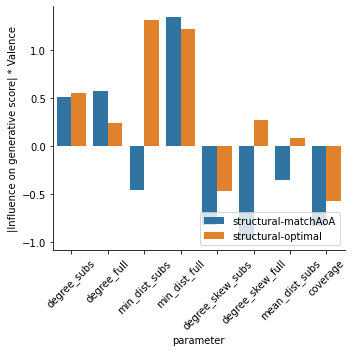

In [11]:
### Get reference values from control samples
# Get diffs from targ value for each random sample
smets2 = sample_mets[
                    ["condition", "pid"] + [
                        "mean_deg_subs", "mean_deg_full",
                        "mean_dist_subs", "coverage",
                        "min_dist_full", "min_dist_subs",
                        "deg_skew_subs", "deg_skew_full"]
                    ]

smets2 = smets2.rename(columns={
                                "mean_deg_full":"degree_full",
                                "mean_deg_subs":"degree_subs",
                                "deg_skew_subs":"degree_skew_subs",
                                "deg_skew_full":"degree_skew_full",
                            })

smets2 = smets2.melt(id_vars=["condition", "pid"])
smets2["condition"] = [
                        "aoa"
                        if x == "AoA"
                        else "random"
                        for x in smets2["condition"]
                      ]
smets2.columns = ["condition", "pid", "variable", "value"]
smets2 = smets2.loc[smets2["condition"] == "random"]


pl_w = pl[
            ["condition",
             "variable",
             "value",
             "weight",
             "restart"]
        ]

pl_w = pl_w.merge(
                    smets2[["variable", "value", "pid"]],
                    on=["variable"]
                 )
pl_w = pl_w.rename(columns={"variable":"parameter"})


# Get mean difference from each target var
pl_w["diff"] = pl_w["value_x"] - pl_w["value_y"]
pl_w = pl_w[
            ["condition",
             "parameter",
             "value_x",
             "weight",
             "diff", 
             "restart"]
        ].groupby(
            ["condition",
             "restart",
             "parameter"]
        ).agg("mean")

pl_w = pl_w.reset_index()
pl_w.columns = ["condition", "restart",
                "parameter", "value",
                "weight", "diff"]

pl_w["influence"] = pl_w["weight"] * pl_w["diff"]
pl_w = pl_w.rename(
            columns={"condition_x":"condition"}
            )

norm = plt.Normalize(pl_w.influence.min(), pl_w.influence.max())

plt.rcParams['font.size'] = '10'
cmap = plt.get_cmap("viridis")



plt.figure(facecolor="white", figsize=(40,20))

sns.catplot(x="parameter", hue="condition", y="influence", data=pl_w, kind="bar",
           order=[
                   "degree_subs", "degree_full",
                   "min_dist_subs", "min_dist_full",
                   "degree_skew_subs", "degree_skew_full",
                   "mean_dist_subs", "coverage"], legend=None)
plt.xticks(rotation=45)
plt.ylabel("|Influence on generative score| * Valence")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Figures/learned_param_values.png")

plt.show()

### Examine generated sequences

In [12]:
#### Repeat these analyses, but for the partitioned data
# Compare the structural to the optimal agent
labels = {
        "controlIncAoA": "Control",
        "AoA": "AoA",
        "synthProbIncAoA": "matchAoA",
        "synthOptIncAoA": "taskOptimised"
}

all_seqs = pd.DataFrame({})


df_aoa = pd.read_csv(
            os.path.join(
                rootdir,
                "results/sample_sequences/AoA_sequences.csv")
                )
df_control = pd.read_csv(
                os.path.join(
                    rootdir,
                    "results/sample_sequences/controlIncAoA_sequences.csv")
                        )
df_optimal = pd.read_csv(
                os.path.join(
                    rootdir,
                    "results/sample_sequences/synthOptIncAoA_sequences.csv")
                    )
df_structural = pd.read_csv(
                    os.path.join(
                        rootdir,
                        "results/sample_sequences/synthProbIncAoA_sequences.csv")
                       )

all_seqs = pd.concat([df_aoa, df_control, df_optimal, df_structural])

all_seqs["condition"] = [labels[x] for x in all_seqs["condition"]]
    
all_seqs = all_seqs.loc[all_seqs["month"] <= 24]

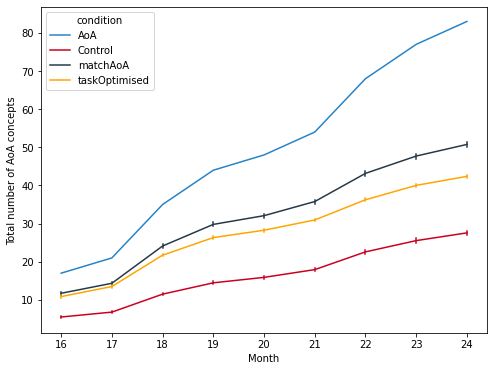

In [13]:
aoa = pd.read_csv(
            os.path.join(
                rootdir,
                "assets/aoa_data/aoa_data_EN.csv"
            )
        )
all_seqs["aoa"] = [int(x in list(aoa["definition"])) for x in all_seqs["concept"]]

all_seq = all_seqs[
                    ["pid", "condition", "aoa", "month"]
                ].groupby(
                    ["pid", "condition", "month"]
                ).agg("sum").reset_index()
all_seq = all_seq.sort_values(["month", "condition"])
all_seq["csum"] = all_seq[
                        ["pid", "condition", "aoa"]
                    ].groupby(
                        ["pid", "condition"]
                    )["aoa"].cumsum()

palette = {
        "Control": "#ca0020",
        "AoA": "#2683C6",
        "matchAoA": "#253848",
        "taskOptimised": "orange"
}

plt.figure(facecolor="white", figsize=(8,6))
sns.lineplot(data=all_seq, x="month", y="csum", hue="condition",
             palette=palette, err_style="bars", ci=95)
plt.xlabel("Month")
plt.ylabel("Total number of AoA concepts")
plt.savefig("Figures/proportion_aoa.png")
plt.show()


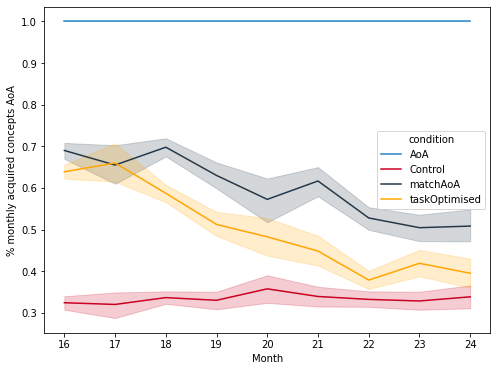

In [14]:
# AoA proportions
aoa_bymonth = all_seqs[["pid", "month", "condition", "aoa"]].groupby(["condition", "pid", "month"]).agg("mean")
#aoa_bymonth = aoa_bymonth.groupby(["month", "condition"]).agg(["mean", "std"]).reset_index()

palette = {
        "Control": "#ca0020",
        "AoA": "#2683C6",
        "matchAoA": "#253848",
        "taskOptimised": "orange"
}

plt.figure(facecolor="white", figsize=(8,6))
sns.lineplot(data = aoa_bymonth, x = "month", y="aoa",
             hue="condition", palette=palette)
plt.xlabel("Month")
plt.ylabel("% monthly acquired concepts AoA")
plt.savefig("Figures/AoA_pct_monthly.png")
plt.show()

In [15]:
new_cats = pd.read_csv(os.path.join(
                                rootdir,
                                "assets/external_features/uncategorised_addn.csv"),
                       index_col=0, header=0) # Categories
new_cats["category"] = [
                        "household" if x == "office"
                        else x for x in new_cats["category"]]
new_cats["category"] = [
                        "food_drink"
                        if x == "games_routines" else x for x in new_cats["category"]]
new_cats = new_cats[["concept", "category"]].drop_duplicates()
new_cats = new_cats.rename(
    columns={"category":"new_category"}
)
cats = all_seqs.merge(new_cats[["new_category", "concept"]], on="concept")

old_cats = pd.read_csv(os.path.join(
                                rootdir,
                                "assets/aoa_data/aoa_data_EN.csv"),
                       index_col=0, header=0)
old_cats = old_cats.rename(
    columns={"category":"old_category",
             "definition":"concept"}
)
old_cats = old_cats[
                    ["concept", "old_category"]
                ].drop_duplicates()
cats = cats.merge(old_cats[
                        ["old_category", "concept"]
                    ], on="concept", how="left")
cats = cats[
            ["concept", "old_category", "new_category"]
            ].drop_duplicates()
cats["change"] = cats["old_category"] != cats["new_category"]


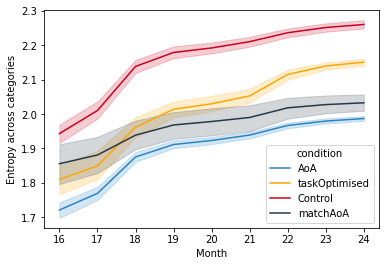

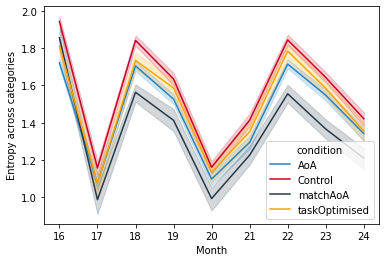

In [16]:
## Calculate within-month entropy
df = pd.read_csv(os.path.join(
                        rootdir,
                        "assets/external_features/uncategorised_addn.csv"),
                 index_col=0, header=0) # Categories
aoa = pd.read_csv(
            os.path.join(
                rootdir,
                "assets/aoa_data/aoa_data_EN.csv"
            )
        )
aoa = aoa.loc[aoa["definition"].isin(vocab)]

df = df[["concept", "category"]]
df["category"] = [
                    "household"
                    if x == "office"
                    else x for x in df["category"]]
df["category"] = [
                    "food_drink"
                    if x == "games_routines"
                    else x for x in df["category"]]

c = df[["concept", "category"]].drop_duplicates()
c["aoa"] = [
            x in list(aoa["definition"])
            for x in c["concept"]]
cats = all_seqs.merge(c[["category", "concept"]], on="concept")

ent = analysis.get_response_entropy(cats, entropy="to_date")
ent = ent[
            ["pid",
             "condition",
             "entropy",
             "month"]
        ].drop_duplicates()

plt.figure(facecolor="white")
sns.lineplot(x="month", y="entropy", hue="condition", data=ent, palette=palette)
plt.xlabel("Month")
plt.ylabel("Entropy across categories")
plt.savefig("Figures/Overall_entropy.png")
plt.show()


ent = analysis.get_response_entropy(cats)
ent = ent[["pid", "condition", "entropy", "month"]].drop_duplicates()

plt.figure(facecolor="white")
sns.lineplot(x="month", y="entropy", hue="condition", data=ent, palette=palette)
plt.xlabel("Month")
plt.ylabel("Entropy across categories")
plt.savefig("Figures/Monthwise_entropy.png")
plt.show()



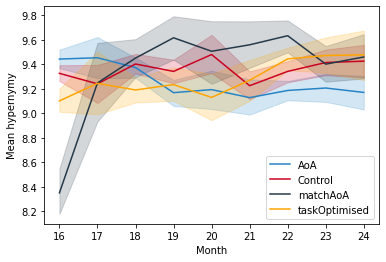

In [17]:
hypernymy = pd.read_csv(os.path.join(
                            rootdir,
                            "assets/external_features/hypernymy.csv"),
                        index_col=0)
hypernymy.columns = ["concept", "hypernymy"]

hypernymy = all_seqs.merge(hypernymy, on="concept")

    
hypernymy = hypernymy[["condition", "pid", "month", "hypernymy"]].groupby(["condition", "pid", "month"]).agg("mean")
#hypernymy= hypernymy.groupby(["condition", "month"]).agg(["mean", "std"]).reset_index()

plt.figure(facecolor="white")
sns.lineplot(x="month", y="hypernymy",
             hue="condition", data=hypernymy, palette=palette)
plt.xlabel("Month")
plt.ylabel("Mean hypernymy")
plt.legend(loc="lower right")
plt.savefig("Figures/Hypernymy_over_time.png")
plt.show()


In [18]:

hypernymy = pd.read_csv(os.path.join(
                            rootdir,
                            "assets/external_features/hypernymy.csv"),
                        index_col=0)
hypernymy.columns = ["concept", "hypernymy"]

hypernymy = all_seqs.merge(hypernymy, on="concept")
hypernymy = hypernymy[
    ["condition", "pid", "month", "hypernymy"]
].groupby(["condition", "pid", "month"]).agg("mean").reset_index()

conds = []
betas = []
consts = []
pvals = []

for cond in hypernymy["condition"].unique():
    print("Condition = {}".format(cond))
    dat = hypernymy.loc[hypernymy["condition"] == cond]
    X = dat["month"]
    y = dat['hypernymy']
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    conds.append(cond)
    betas.append(est2.params["month"])
    pvals.append(est2.pvalues.loc["month"])
    consts.append(est2.params["const"])
    

print(conds, betas, pvals, consts)

Condition = AoA
                            OLS Regression Results                            
Dep. Variable:              hypernymy   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     21.94
Date:                Thu, 08 Sep 2022   Prob (F-statistic):           3.02e-06
Time:                        17:46:26   Log-Likelihood:                -2312.3
No. Observations:                1800   AIC:                             4629.
Df Residuals:                    1798   BIC:                             4640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0066      0.161    

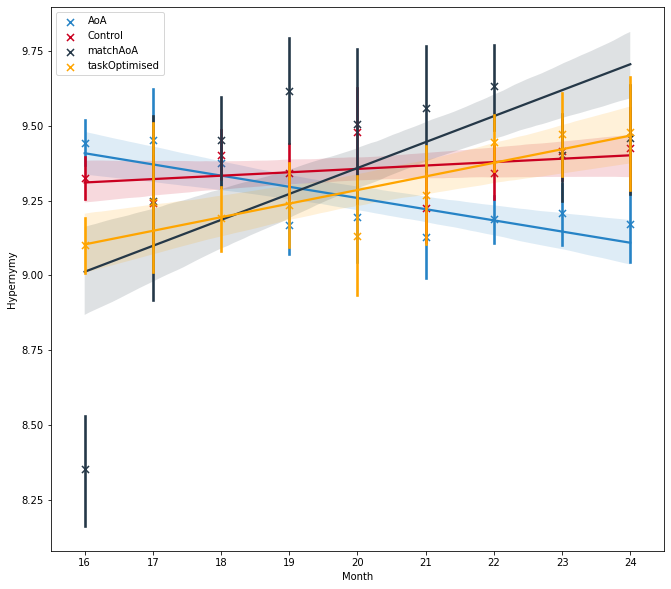

In [19]:
fig, ax = plt.subplots(figsize=(11,10))


color_dict = {
    "Control":"#ca0020",
    "AoA": "#2683C6",
    "Structural-Optimal": "orange",
    "Structural-MatchAoA": "#253848",
}

hypernymy["month"] = pd.to_numeric(hypernymy["month"])

for i, cond in enumerate(conds):
    sns.regplot(x="month", y="hypernymy", data=hypernymy.loc[hypernymy["condition"] == cond],
            x_estimator=np.mean, ax=ax, color=palette[cond], marker="x",label=cond,
                scatter_kws={"s":50, })
plt.xlim(15.5, 24.5)
plt.legend()
plt.xlabel("Month")
plt.ylabel("Hypernymy")
plt.savefig("Figures/Hypernymy_trends.png")
plt.show()


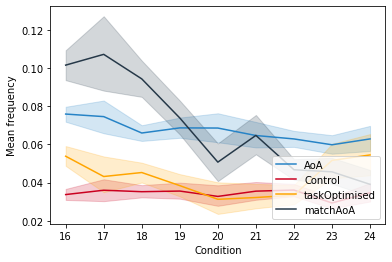

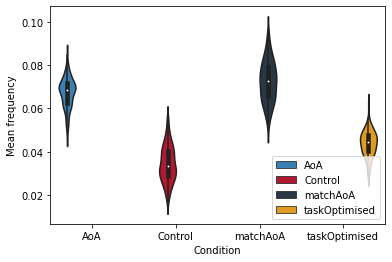

In [20]:
# Frequency based on condition

#### Repeat these analyses, but for the partitioned data
# Compare the structural to the optimal agent
labels = {
        "controlIncAoA": "Control",
        "AoA": "AoA",
        "synthProbIncAoA": "matchAoA",
        "synthOptIncAoA": "taskOptimised"
}


# Get log frequencies averaged across domains
img_cnt = pd.read_csv(os.path.join(
                        rootdir,
                        "assets/external_features/img_freq_bbox.csv"),
                      header=0, index_col=0)
# Map class IDs to labels
img_cnt = img_cnt.rename(columns={"wd":"LabelName", "count":"img_count"})
img_lab = pd.read_csv(os.path.join(
                        rootdir,
                        "assets/external_features/class-descriptions-boxable.csv"),
                      header=0)
img_lab = img_lab.rename(columns={"DisplayName":"wd"})
img_lab["concept"] = [x.lower() for x in img_lab["wd"]]

img_cnt = img_cnt.merge(img_lab, how="left", on="LabelName")
img_cnt = img_cnt.drop(columns="LabelName")

# Import wd frequencies
wd_cnt = pd.read_csv(os.path.join(
                        rootdir,
                        "assets/external_features/unigram_freq.csv"),
                     header=0, index_col=None)
wd_cnt = wd_cnt.rename(columns={"count":"wd_count", "word":"concept"})

# Merge frequencies
freqs = wd_cnt.merge(img_cnt, on="concept", how="outer")
freqs = freqs.dropna()

freqs = all_seqs.merge(freqs, on="concept")

freqs["img_count"] = freqs["img_count"]/np.max(freqs["img_count"])
freqs["wd_count"] = freqs["wd_count"]/np.max(freqs["wd_count"])

freqs["mean_count"] = (freqs["img_count"] + freqs["wd_count"])/2

plt.figure(facecolor="white")
sns.lineplot(x="month", y="mean_count",
             hue="condition", data=freqs, palette=palette)
plt.xlabel("Condition")
plt.ylabel("Mean frequency")
plt.legend(loc="lower right")
plt.savefig("Figures/Frequency_trends_bycond_include.png")
plt.show()

freqs = freqs[["condition", "pid", "img_count", "wd_count", "mean_count"]].groupby(["condition", "pid"]).agg("mean")
freqs = freqs.reset_index()
plt.figure(facecolor="white")
sns.violinplot(x="condition", y="mean_count",
             hue="condition", data=freqs, palette=palette)
plt.xlabel("Condition")
plt.ylabel("Mean frequency")
plt.legend(loc="lower right")
plt.savefig("Figures/Frequency_boxplots_bycond_include.png")
plt.show()


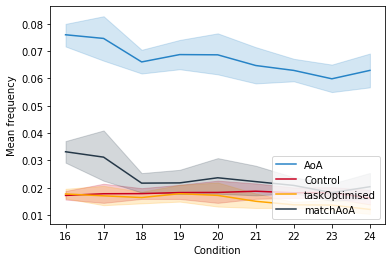

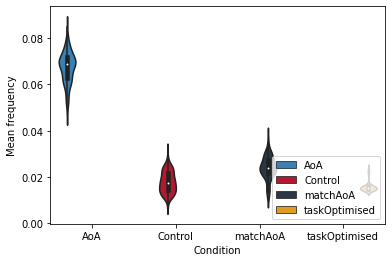

In [21]:
#### Repeat these analyses, but for the partitioned data
# Compare the structural to the optimal agent
labels = {
        "controlExcAoA": "Control",
        "AoA": "AoA",
        "synthProbExcAoA": "matchAoA",
        "synthOptExcAoA": "taskOptimised"
}

all_seqs = pd.DataFrame({})


df_control_exc = pd.read_csv(
                os.path.join(
                    rootdir,
                    "results/sample_sequences/controlExcAoA_sequences.csv")
                        )
df_optimal_exc = pd.read_csv(
                os.path.join(
                    rootdir,
                    "results/sample_sequences/synthOptExcAoA_sequences.csv")
                    )
df_structural_exc = pd.read_csv(
                    os.path.join(
                        rootdir,
                        "results/sample_sequences/synthProbExcAoA_sequences.csv")
                       )

all_seqs_exc = pd.concat(
                        [df_aoa,
                         df_control_exc,
                         df_optimal_exc,
                         df_structural_exc]
                    )

all_seqs_exc["condition"] = [labels[x] for x in all_seqs_exc["condition"]]
    
all_seqs_exc = all_seqs_exc.loc[all_seqs_exc["month"] <= 24]


# Merge frequencies
freqs = wd_cnt.merge(img_cnt, on="concept", how="outer")
freqs = freqs.dropna()

freqs = all_seqs_exc.merge(freqs, on="concept")

freqs["img_count"] = freqs["img_count"]/np.max(freqs["img_count"])
freqs["wd_count"] = freqs["wd_count"]/np.max(freqs["wd_count"])

freqs["mean_count"] = (freqs["img_count"] + freqs["wd_count"])/2
print

plt.figure(facecolor="white")
sns.lineplot(x="month", y="mean_count",
             hue="condition", data=freqs, palette=palette)
plt.xlabel("Condition")
plt.ylabel("Mean frequency")
plt.legend(loc="lower right")
plt.savefig("Figures/Frequency_trends_bycond_exclude.png")
plt.show()

freqs = freqs[["condition", "pid", "img_count", "wd_count", "mean_count"]].groupby(["condition", "pid"]).agg("mean")
freqs = freqs.reset_index()
plt.figure(facecolor="white")
sns.violinplot(x="condition", y="mean_count",
             hue="condition", data=freqs, palette=palette)
plt.xlabel("Condition")
plt.ylabel("Mean frequency")
plt.legend(loc="lower right")
plt.savefig("Figures/Frequency_boxplots_bycond_exclude.png")
plt.show()